<a href="https://colab.research.google.com/github/adrabi-abderrahim/QClass23-24/blob/main/Data_reuploading_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook we use data re-uploading encoding method to create a Quantum machine learn model in order to classify Iris flowers named Setosa and Versicolor with thier petal and sepal lenghts.

To this end, we use a quantum circuit with only `1 qubit` to achieve an accuracy of `100%`.

The code is self-explanatory, it follows the classical steps of machine learning:
- Data Encoding,
- A model definition, and
- A training loop.

For the optimizer, we choosed Adam with `learning rate = 0.1`, a neural network with `4` nodes and `1` hidden layer.

See [Data-reuploading classifier](https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier/) for more explanation.

**To be honest**, I am inspired from the code in [Undergraduate Thesis: Quantum Image Classifier Design with Data Re-uploading Quantum Convolution and Data Re-uploading Classifier Scheme](https://github.com/ericardomuten/quantum_image_classifier) by Eraraya Ricardo Muten.

*Hoping to meet the Judging criteria, we will give the following details:*

- **QML model**

  We used a quantum circuit of `1` qubit as a proof of concept that QML "could" be better than classical one. In my reasoning, if we can't use less layers and nodes in QML then classical ML. Then, Quantum ML is useless.

  Also, it not a matter of numbers of layers and nodes only, but we need models than train faster, cheaper (in the future maybe), and with a near-perfect accuracy.

- **Data uploading / encoding method**

  Encoding data to quantum qubits is worst than classical counterparty, even in the simulation case. So, **data re-uploading** gives a smart and cheap (i.e in terms of the number of qubits used not the deep the circuit) way to do so, We liked it.

- **Cost function**

  We only normalize the sum the absolute values of each fidelity minus `1` i.e. $\sum_{i}^n \frac{|1-f_i|}{n}$. It is no need to complicate life and lost time on unnecessary  computations. Remember, we want a fast trainig model.

- **Optimization method**

  Adam optimizer works fine. We noticed that when `stepsize` is bigger the accuracy start jumping from value to another in a rotation like Grover's Algorithm as we studied.

In [1]:
!pip install pennylane --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 38.9 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
import pennylane.optimize as optz
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches

from IPython.core.display import display, HTML

import matplotlib.pyplot as plt

# Loading and preprocessing Iris dataset

In this section, we will prepare the dataset for training by removing unnecessary features and classes. Also, we will normalize data and pad it for training.

In [3]:
# Loading Iris dataset from scikit-lean datasets
iris = datasets.load_iris()

In [4]:
# Filter dataset to get indeces of Setosa and Versicolour flowers
indexes = np.where(iris.target != 2)

# Keep features petal and sepal lengths
x_data = iris.data[indexes][:, [0, 2]]

# Get classes of Setosa and Versicolour flowers
y_data = iris.target[indexes]

In [5]:
# Noramalize data into the interval [-1 , 1]
nearest_ceil = 10**6
x_data = np.ceil(nearest_ceil * np.cos(np.pi * x_data, requires_grad=False))/nearest_ceil

# Assert the normalization
assert x_data.min() >= -1
assert x_data.max() <= 1

In [6]:
# Since we have only two features and the paper forces the use of the gate Rotation(a, b, c),
# we need to pad the dataset to three element per row.
x_data = np.hstack((x_data, np.reshape(y_data, (-1, 1))))

# Asset the padding
assert x_data.shape == (len(indexes[0]), 3)

# Utils

A collection of utils for this task.

In [7]:
# Since (the current) quantum computing is just a linear algebra (with some other stuff). So, we encode the targets using one-hot encoding like this:
# 0 -> Some hermitian matrix
# 1 -> Some hermitian matrix different for the one for the class "0"

op_target = np.array([
    [[1, 0], [0, 0]],
    [[0, 0], [0, 1]],
    ], requires_grad=False
)

# Quantum Model

The model in this case is a quantum circit with one qubit (i.e. wire).
The current model is inspered from the demo [Data-reuploading classifier](https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier/).

In [8]:
# The circuit of the model uses only 1 qubit

@qml.qnode(qml.device("lightning.qubit", wires = 1))
def circuit(params, x, y):

  for i in range(len(params[0])):
    # Perceptron
    qml.Rot(*(params[0][i] * x + params[1][i]), wires=0)

  return qml.expval(qml.Hermitian(y, wires=[0]))

Expectation value:  0.5853897650697074


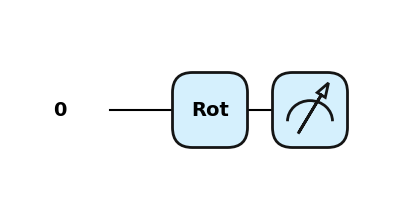

In [9]:
# Show the circuit for one node
test_params = [
    np.random.uniform(size=(1, 3), requires_grad=False),
    np.random.uniform(size=(1, 3), requires_grad=False),
    ]
qml.draw_mpl(circuit, style='pennylane')(test_params, test_params[0][0], op_target[0])
print('Expectation value: ', circuit(test_params, test_params[0][0], op_target[0]))

del test_params

#Cost Function

Here, the cost function is defined and it uses the quantum circuit to calculate the fidelities of the entries passed via input.

In [10]:
# Summing the fidelities for all the data points after passing through the circuit
def cost(params, x, y):
  loss = 0.0
  for i in range(len(x)):
    f = circuit(params, x[i], op_target[y[i]])
    # Keep it simple
    loss = loss + np.abs(1 - f)
  return loss / len(x)

In [11]:
# Predict the class of an input using parameters on the quantum circuit
def predict(params, x):
  fidelity_values = []
  predicted = []

  for i in range(len(x)):
    fidelities = [circuit(params, x[i], t) for t in op_target]
    best_fidel = np.argmax(fidelities)
    predicted.append(best_fidel)
    fidelity_values.append(fidelities)

  return np.array(predicted), np.array(fidelity_values)

# Training Loop

The training loop that uses an optimazer to find best parameters.

In [12]:
# Training parameters
num_nodes = 4
learning_rate = 0.1
epochs = 10
batch_size = 2**3

# Splitting data
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=53)

In [13]:
# Initializing the optimizer
opt = optz.AdamOptimizer(learning_rate)

params = np.array([
  np.random.uniform(size=(num_nodes, 3)), # Weights
  np.random.uniform(size=(num_nodes, 3))  # Biais
])

In [14]:
accuracy_train, accuracy_test = 0, 0

# The training loop
for e in range(epochs):

  # Train the batch of the dataset
  for idx in gen_batches(len(x_train), batch_size):
      params, _, _= opt.step(cost, params, x_train[idx], y_train[idx])

  # Get the predicted results using training dataset
  predicted_train, fidel_train = predict(params, x_train)
  accuracy_train = metrics.accuracy_score(y_train, predicted_train)

  # Calculate the loss
  loss = cost(params, x_train, y_train)

  # Get the predicted results using testing dataset to compare the behaviour
  # of the model on the training dataset and test dataset.
  predicted_test, fidel_test = predict(params, x_test)
  accuracy_test = metrics.accuracy_score(y_test, predicted_test)

  # Print important information on the screen
  res = [e + 1, loss, accuracy_train, accuracy_test]
  print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

# Show an emoji if the accuracy of the training and testing is 100%
if accuracy_train == 1 and accuracy_test == 1:
    display(HTML('<h1>&#127881 Jackpot!</h1>'))

Epoch:  1 | Loss: 0.314594 | Train accuracy: 0.787500 | Test accuracy: 0.900000
Epoch:  2 | Loss: 0.104709 | Train accuracy: 1.000000 | Test accuracy: 1.000000
Epoch:  3 | Loss: 0.034892 | Train accuracy: 1.000000 | Test accuracy: 1.000000
Epoch:  4 | Loss: 0.017264 | Train accuracy: 1.000000 | Test accuracy: 1.000000
Epoch:  5 | Loss: 0.004646 | Train accuracy: 1.000000 | Test accuracy: 1.000000
Epoch:  6 | Loss: 0.004377 | Train accuracy: 1.000000 | Test accuracy: 1.000000
Epoch:  7 | Loss: 0.002083 | Train accuracy: 1.000000 | Test accuracy: 1.000000
Epoch:  8 | Loss: 0.000604 | Train accuracy: 1.000000 | Test accuracy: 1.000000
Epoch:  9 | Loss: 0.000245 | Train accuracy: 1.000000 | Test accuracy: 1.000000
Epoch: 10 | Loss: 0.000227 | Train accuracy: 1.000000 | Test accuracy: 1.000000


In [15]:
# Just predict all the element of the dataset at once
x_data_prediction, x_data_fidels = predict(params, x_data)
accuracy_x_data = metrics.accuracy_score(y_data, x_data_prediction)
print('The accuracy of all dataset is:', accuracy_x_data)

The accuracy of all dataset is: 1.0
